## Correlation matrix

In [ ]:
from image_text_model.im_text_rnn_model import correlation_matrix

nb_batches = 781
checkpoint_dir = 'image_text_model/deep_sentiment_model'
#posts_logits, posts_labels = correlation_matrix(nb_batches, checkpoint_dir)

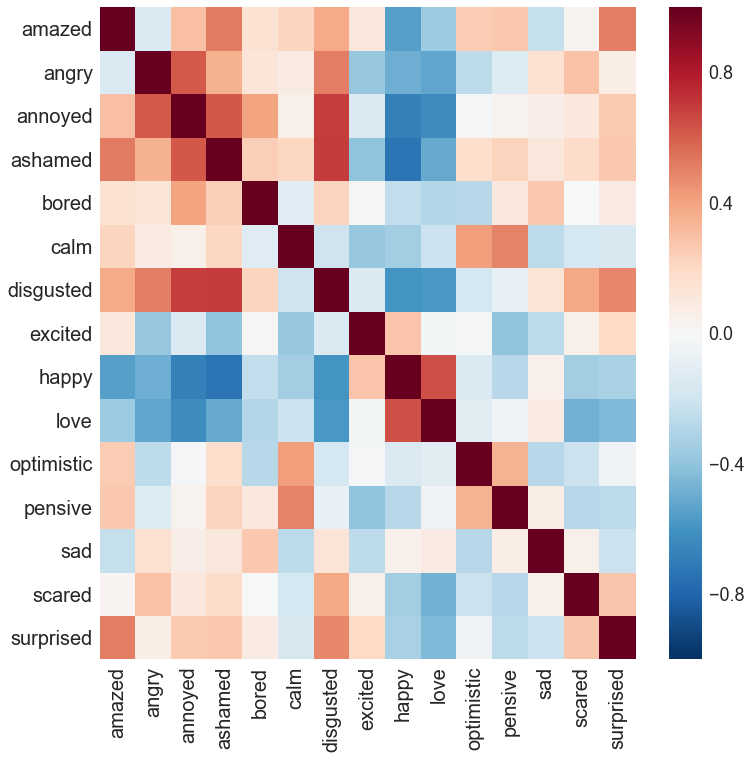

In [9]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from datasets.dataset_utils import read_label_file
%matplotlib inline

posts_logits = np.load('data/posts_logits.npy')
posts_logits = posts_logits[:, range(9) + range(10, 16)]
labels_dict = read_label_file('data', 'photos', filename='labels_all_15.txt')
corr_matrix = np.corrcoef(posts_logits, rowvar=False)

fig, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(corr_matrix, ax=ax)
graph_labels = [(int)(item.get_text()) for item in ax.get_xticklabels()]
ax.set_xticklabels(map(lambda x: labels_dict[x], graph_labels))
ax.set_yticklabels(map(lambda x: labels_dict[x], graph_labels[::-1]))
for label in (ax.get_xticklabels()):
    label.set_fontsize(20)
for label in (ax.get_yticklabels()):
    label.set_fontsize(20)
# Legend ticks size
cax = plt.gcf().axes[-1]
cax.tick_params(labelsize=18)

plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.savefig('plots/correlation_matrix.pdf', dpi=300)
plt.show()

//anaconda/envs/tensorflow/lib/python2.7/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


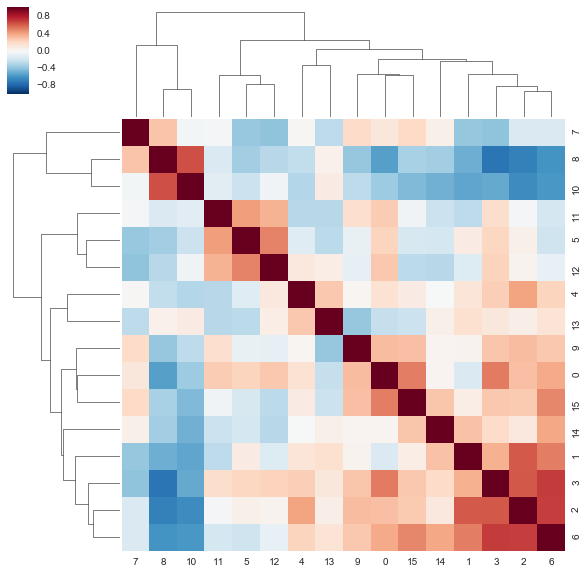

In [2]:
cg = sns.clustermap(corr_matrix)
#for i, ax in enumerate(cg.fig.axes):   # get all axes of the fig object
    #graph_labels = [(int)(item.get_text()) for item in ax.get_xticklabels()]
    #ax.set_xticklabels(map(lambda x: labels_dict[x], graph_labels), rotation=90)
    #ax.set_yticklabels(map(lambda x: labels_dict[x], graph_labels[::-1]), rotation=0)
plt.savefig('plots/dendogram2.png', dpi=300)
plt.show()

#import scipy.spatial as sp
#linkage1 = linkage(sp.distance.squareform(1 - corr_matrix, checks=False), method='average')
#sns.clustermap(1 - corr_matrix, row_linkage=linkage1, col_linkage=linkage1)

In [12]:
from scipy.cluster.hierarchy import dendrogram, linkage
Z = linkage(corr_matrix, 'ward')

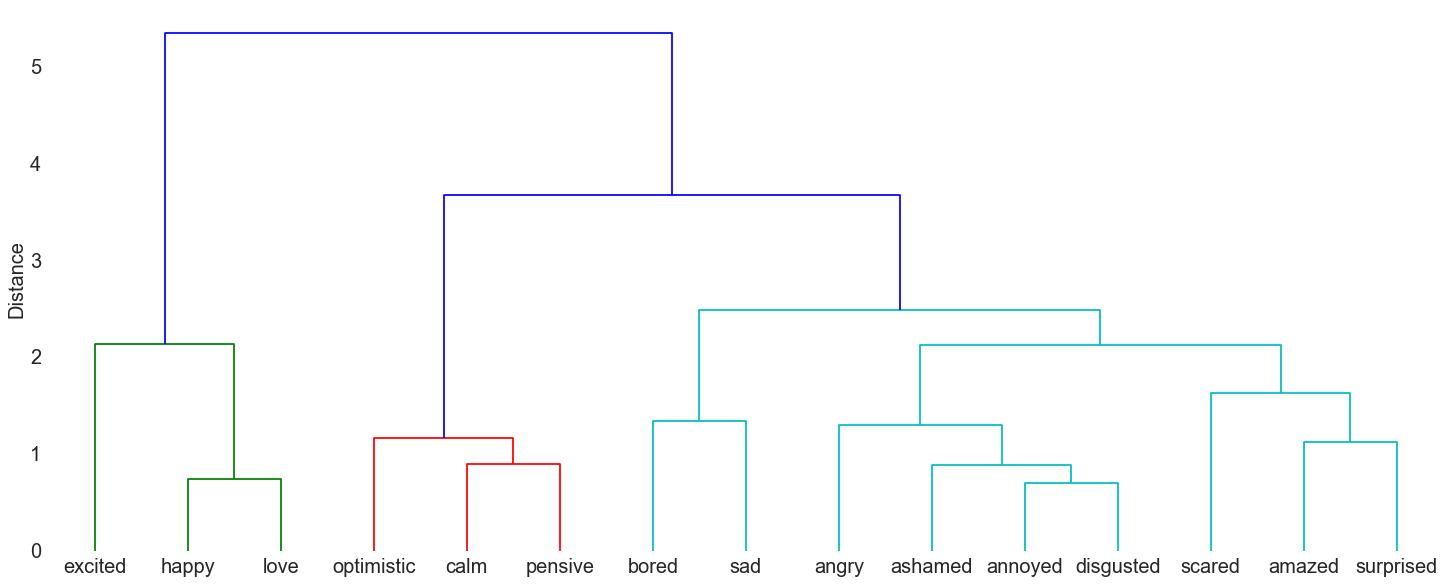

In [42]:
fig = plt.figure(figsize=(25, 10))
ax = fig.add_subplot(111)
ax.set_facecolor('white')
plt.ylabel('Distance')
R = dendrogram(Z, color_threshold=3,
               leaf_font_size=20,  # font size for the x axis labels
               labels=labels_dict.values())
ax.yaxis.label.set_size(20)
for label in (ax.get_yticklabels()):
    label.set_fontsize(20)
ax.grid(False)
plt.savefig('plots/dendrogram_clean.png', dpi=300)
plt.show()

## PCA/MDS

In [9]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from datasets.dataset_utils import read_label_file
%matplotlib inline

random_seed = 0
posts_logits = np.load('data/posts_logits.npy')
posts_labels = np.load('data/posts_labels.npy')
labels_dict = read_label_file('data', 'photos', filename='labels_all.txt')

np.random.seed(random_seed)
nb_samples = 45000
nb_posts_per_emotion = 150
indices = np.random.choice(posts_logits.shape[0], nb_samples, replace=False)
posts_logits = posts_logits[indices]
posts_labels = posts_labels[indices]

In [10]:
# Generate equal weights emotion posts
equal_indices = []
for i in range(len(labels_dict)):
    if i != 9:
        equal_indices.append(np.where(posts_labels == i)[0][:nb_posts_per_emotion])
        
equal_indices = np.hstack(equal_indices)
posts_logits = posts_logits[equal_indices]
posts_labels = posts_labels[equal_indices]
posts_logits.shape

(2250, 16)

In [45]:
# Import for R
reduced_posts_logits = posts_logits[:, range(9) + range(10, 16)]
reduced_labels_dict = read_label_file('data', 'photos', filename='labels_all_15.txt')

In [53]:
#np.savetxt('plots/reduced_posts_logits.txt', reduced_posts_logits)

In [52]:
['amazed', 'angry', 'annoyed', 'ashamed', 'bored', 'calm', 'disgusted', 'excited', 'happy', 'love', 
 'optimistic', 'pensive', 'sad', 'scared', 'surprised']

[u'amazed', u'angry', u'annoyed', u'ashamed', u'bored', u'calm', u'disgusted', u'excited', u'happy', u'love', u'optimistic', u'pensive', u'sad', u'scared', u'surprised']


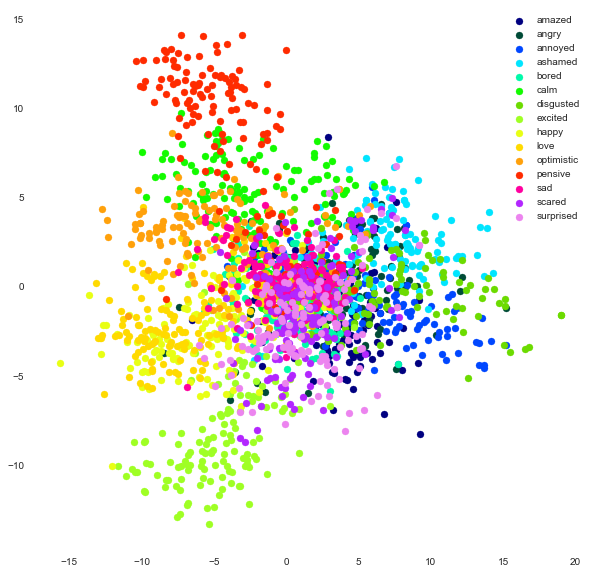

In [11]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
pca_points = pca.fit_transform(posts_logits)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
for label in labels_dict.keys():
    if labels_dict[label] != 'interested':
        mask = posts_labels == label
        ax.scatter(pca_points[mask, 0], pca_points[mask, 1], label=labels_dict[label])
colormap = plt.cm.gist_ncar#nipy_spectral, Set1,Paired  
colorst = [colormap(i) for i in np.linspace(0, 0.9, len(ax.collections))]       
for t, j1 in enumerate(ax.collections):
    j1.set_color(colorst[t])

ax.grid(False)
ax.set_facecolor('white')
ax.legend()
#plt.savefig('plots/pca2-3.pdf', dpi=300)
plt.show()

In [59]:
pca.explained_variance_ratio_

array([ 0.28926983,  0.17945906,  0.13854235])

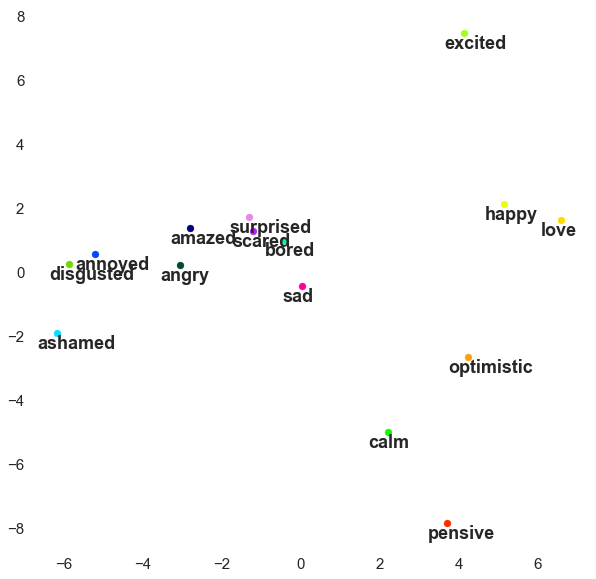

In [39]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
for label in labels_dict.keys():
    mask = posts_labels == label
    if labels_dict[label] != 'interested':
        ax.scatter(-pca_points[mask, 0].mean(), -pca_points[mask, 1].mean(), label=labels_dict[label])
        ax.annotate(labels_dict[label], (-pca_points[mask, 0].mean() - 0.5, -pca_points[mask, 1].mean() - 0.5), 
                    size=18, fontweight='bold') #, **hfont)
colormap = plt.cm.gist_ncar 
colorst = [colormap(i) for i in np.linspace(0, 0.9, len(ax.collections))]       
for t, j1 in enumerate(ax.collections):
    j1.set_color(colorst[t])

for label in (ax.get_xticklabels()):
    label.set_fontsize(15)
for label in (ax.get_yticklabels()):
    label.set_fontsize(15)
#ax.legend()
ax.grid(False)
ax.set_facecolor('white')
#plt.savefig('plots/pca2v3-centroids.pdf', dpi=300)
plt.show()

In [64]:
import plotly.plotly as py
from plotly.graph_objs import *
import plotly.tools as tls

tls.set_credentials_file(username='anth.hu', api_key='MxqFuCEwTiyJwJeBqfrU')
# plot explained variance https://plot.ly/ipython-notebooks/principal-component-analysis/

traces = []

for label in labels_dict.keys():
    mask = posts_labels == label
    if labels_dict[label] != 'interested':
        trace = Scatter(
            x=-pca_points[mask, 1],
            y=-pca_points[mask, 2],
            mode='markers',
            name=labels_dict[label],
            marker=Marker(
                size=12,
                line=Line(
                    color='rgba(217, 217, 217, 0.14)',
                    width=.5),
                opacity=0.8))
        traces.append(trace)


data = Data(traces)
layout = Layout(xaxis=XAxis(title='Dimension 2', showline=False),
                yaxis=YAxis(title='Dimension 3', showline=False))
fig = Figure(data=data, layout=layout)
py.iplot(fig)

In [97]:
from sklearn.manifold import MDS

# image with random_satate 9 and 1000 points
mds = MDS(n_components=2, random_state=9)
mds_points = mds.fit_transform(posts_logits)

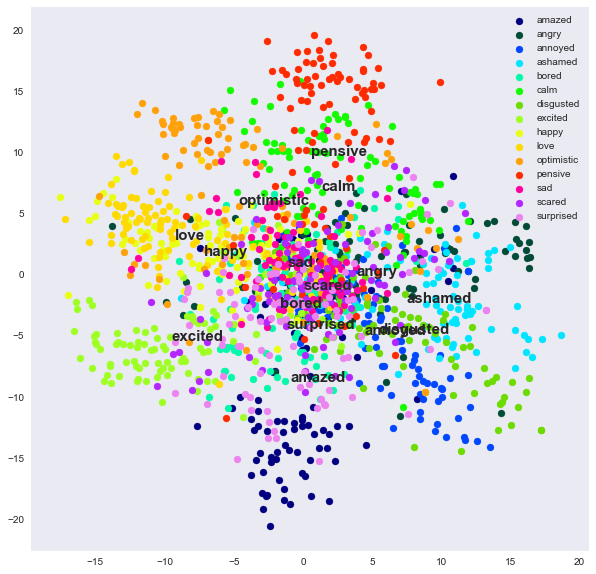

In [61]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
for label in labels_dict.keys():
    mask = posts_labels == label
    if labels_dict[label] != 'interested':
        ax.scatter(-mds_points[mask, 0], mds_points[mask, 1], label=labels_dict[label])
        ax.annotate(labels_dict[label], (-mds_points[mask, 0].mean() - 0.8, mds_points[mask, 1].mean() - 0.5), 
                    size=15, fontweight='bold')
colormap = plt.cm.gist_ncar 
colorst = [colormap(i) for i in np.linspace(0, 0.9, len(ax.collections))]       
for t, j1 in enumerate(ax.collections):
    j1.set_color(colorst[t])

ax.legend()
ax.grid(False)
#plt.savefig('plots/mds.png', dpi=300)
plt.show()

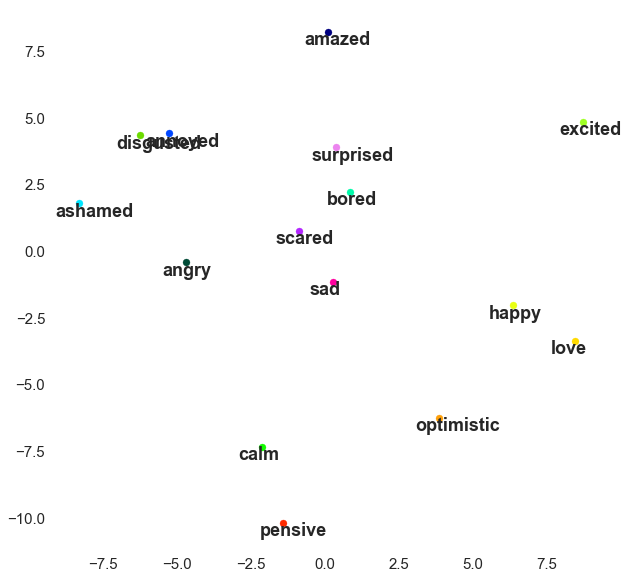

In [99]:
#hfont = {'fontname': 'DejaVu Sans'}

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
for label in labels_dict.keys():
    mask = posts_labels == label
    if labels_dict[label] != 'interested':
        ax.scatter(mds_points[mask, 0].mean(), -mds_points[mask, 1].mean(), label=labels_dict[label])
        ax.annotate(labels_dict[label], (mds_points[mask, 0].mean() - 0.8, -mds_points[mask, 1].mean() - 0.5), 
                    size=18, fontweight='bold') #, **hfont)
colormap = plt.cm.gist_ncar 
colorst = [colormap(i) for i in np.linspace(0, 0.9, len(ax.collections))]       
for t, j1 in enumerate(ax.collections):
    j1.set_color(colorst[t])

for label in (ax.get_xticklabels()):
    label.set_fontsize(15)
for label in (ax.get_yticklabels()):
    label.set_fontsize(15)
#ax.legend()
ax.grid(False)
ax.set_facecolor('white')
#ax.set_xlim(-22, 17)
#ax.set_ylim(-18, 18)
#plt.savefig('plots/mds-centers.png', dpi=300)
plt.show()

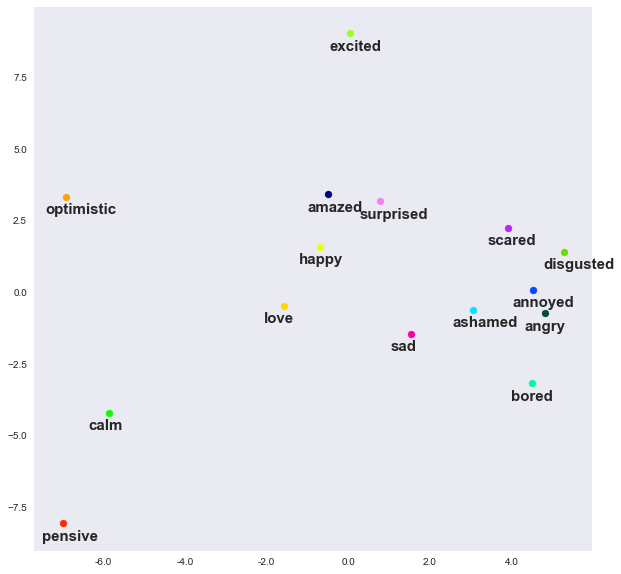

In [31]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
for label in labels_dict.keys():
    mask = posts_labels == label
    if labels_dict[label] != 'interested':
        ax.scatter(-mds_points[mask, 1].mean(), -mds_points[mask, 2].mean(), label=labels_dict[label])
        ax.annotate(labels_dict[label], (-mds_points[mask, 1].mean() - 0.5, -mds_points[mask, 2].mean() - 0.6), 
                    size=15, fontweight='bold')
colormap = plt.cm.gist_ncar 
colorst = [colormap(i) for i in np.linspace(0, 0.9, len(ax.collections))]       
for t, j1 in enumerate(ax.collections):
    j1.set_color(colorst[t])

#ax.legend()
ax.grid(False)
from matplotlib.ticker import FormatStrFormatter
ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
#plt.savefig('plots/mds-centers-2vs3.png', dpi=300)
plt.show()

In [ ]:
More on manifold learning here: https://jakevdp.github.io/PythonDataScienceHandbook/05.10-manifold-learning.html

## Top words for each emotion

In [1]:
import os
import operator

import numpy as np
import pandas as pd
from text_model.text_preprocessing import _load_embedding_weights_glove, preprocess_one_df
from image_text_model.im_text_rnn_model import word_most_relevant
from datasets.dataset_utils import read_label_file

emotions = ['happy', 'sad', 'scared', 'angry', 'surprised', 'disgusted', 'annoyed', 'bored', 
'love', 'calm', 'amazed', 'optimistic', 'pensive', 'ashamed', 'excited'] #removed interested

df_dict = dict()

text_dir = 'text_model'
emb_dir = 'embedding_weights'
filename = 'glove.6B.50d.txt'
vocabulary, embedding = _load_embedding_weights_glove(text_dir, emb_dir, filename)
_POST_SIZE = 50
    
for emotion in emotions:
    df = preprocess_one_df(vocabulary, embedding, emotion, _POST_SIZE)
    df_dict[emotion] = df
    
columns = [u'id', u'post_url', u'type', u'timestamp',
           u'date', u'tags', u'liked', u'note_count',
           u'photo', u'text', u'search_query', u'text_list',
           u'text_len']
df_all = pd.DataFrame(columns = [])

for emotion in emotions:
    df_all = pd.concat([df_all, df_dict[emotion]]).reset_index(drop=True)

Finished loading word embedding weights.


In [40]:
# Get top 1000 most occurring words
vocabulary_count = dict(zip(vocabulary, np.zeros(len(vocabulary), dtype=np.int32)))
for i in range(df_all.shape[0]):
    for word in df_all['text'][i].lower().split():
        if word in vocabulary_count:
            vocabulary_count[word] += 1

In [42]:
import operator
nb_top_words = 1000
most_frequent_words = sorted(vocabulary_count.items(), key=operator.itemgetter(1), reverse=True)[:nb_top_words]

word_to_id = dict(zip(vocabulary, range(len(vocabulary))))
id_most_frequent_words = [word_to_id[x[0]] for x in most_frequent_words]

In [3]:
labels_dict = read_label_file('data', 'photos')
top_words = [41,
 4,
 0,
 5,
 7,
 81,
 3,
 192,
 6,
 12,
 14,
 20,
 285,
 10,
 100,
 34]
num_classes = 7#len(labels_dict)
checkpoint_dir = 'image_text_model/deep_sentiment_model'
#scores, vocabulary, word_to_id = word_most_relevant(top_words, num_classes, checkpoint_dir)

Finished loading word embedding weights.


In [43]:
#######
## Analyse scores
######
import numpy as np
from text_model.text_preprocessing import _load_embedding_weights_glove
from datasets.dataset_utils import read_label_file

labels_dict = read_label_file('data', 'photos', filename='labels_all.txt')

text_dir = 'text_model'
emb_dir = 'embedding_weights'
filename = 'glove.6B.50d.txt'
vocabulary, embedding = _load_embedding_weights_glove(text_dir, emb_dir, filename)

word_to_id = dict(zip(vocabulary, range(len(vocabulary))))
id_to_word = {value:key for key, value in word_to_id.items()}
scores = np.load('data/top_words_scores.npy')
top_words = np.load('data/top_words.npy')

Finished loading word embedding weights.


In [9]:
labels_dict

{0: u'amazed',
 1: u'angry',
 2: u'annoyed',
 3: u'ashamed',
 4: u'bored',
 5: u'calm',
 6: u'disgusted',
 7: u'excited',
 8: u'happy',
 9: u'interested',
 10: u'love',
 11: u'optimistic',
 12: u'pensive',
 13: u'sad',
 14: u'scared',
 15: u'surprised'}

In [62]:
import numpy as np
import operator

emotion_index = 12
relevant_words_emotion = sorted(zip(range(scores.shape[0]), scores[:, emotion_index]), key=operator.itemgetter(1), reverse=True)[:60]
relevant_words_emotion = [x[0] for x in relevant_words_emotion]

print(labels_dict[emotion_index].title())
print(', '.join(map(lambda x: id_to_word[x], top_words[relevant_words_emotion])))

Pensive
mood, wrote, quiet, view, il, trending, ive, sadness, thoughts, calm, words, sad, kissed, depression, de, text, –, voice, y, e, lonely, del, soul, by, read, truth, sounds, middle, peace, listening, late, followers, sense, writing, via, photos, lovely, sat, early, cried, los, house, later, 7, memories, date, tumblr, che, emotional, post, looked, sound, no., cant, deep, write, between, relationship, la, bc


## DeepSentiment with fc layer

In [1]:
from image_text_model.im_text_rnn_model import train_deep_sentiment

checkpoints_dir = 'image_model/pretrained_model'
train_dir = 'image_text_model/deep_sentiment_model_2'
num_steps = 2
train_deep_sentiment(checkpoints_dir, train_dir, num_steps)

Finished loading word embedding weights.
Instructions for updating:
Use tf.losses.softmax_cross_entropy instead.
Instructions for updating:
Use tf.losses.compute_weighted_loss instead.
Instructions for updating:
Use tf.losses.add_loss instead.
Instructions for updating:
Use tf.losses.get_total_loss instead.
Instructions for updating:
Use tf.losses.get_losses instead.
Instructions for updating:
Use tf.losses.get_regularization_losses instead.
INFO:tensorflow:Starting Session.
INFO:tensorflow:Starting Queues.
INFO:tensorflow:global_step/sec: 0
New learning rate: 0.001
INFO:tensorflow:global step 1: loss = 2.7510 (53.36 sec/step)
INFO:tensorflow:global step 2: loss = 2.3407 (30.71 sec/step)
INFO:tensorflow:Stopping Training.
INFO:tensorflow:Finished training! Saving model to disk.
Finished training. Last batch loss 2.341


In [ ]:
from image_text_model.im_text_rnn_model import evaluate_deep_sentiment

checkpoint_dir = 'image_text_model/deep_sentiment_model_2'
log_dir = 'image_text_model/model_eval_2'
mode = 'train'
num_evals = 2
evaluate_deep_sentiment(checkpoint_dir, log_dir, mode, num_evals)

## Outlier detection

In [1]:
from image_text_model.im_text_rnn_model import outliers_detection

# change mode to validation and set nb_batches
####
checkpoint_dir = 'image_text_model/deep_sentiment_model'
#max_norms, max_post_ids, max_logits = outliers_detection(checkpoint_dir)

Finished loading word embedding weights.


In [3]:
max_logits.shape

(64, 8)

In [1]:
import numpy as np
import pandas as pd
from text_model.text_preprocessing import _load_embedding_weights_glove, preprocess_one_df
from datasets.dataset_utils import read_label_file

max_norms = np.load('data/max_norms.npy')
max_post_ids = np.load('data/max_post_ids.npy')
max_logits = np.load('data/max_logits.npy')

In [2]:
emotions = ['happy', 'sad', 'scared', 'angry', 'surprised', 'disgusted', 'annoyed', 'bored', 
'love', 'calm', 'amazed', 'optimistic', 'pensive', 'ashamed', 'excited'] #removed interested

df_dict = dict()

text_dir = 'text_model'
emb_dir = 'embedding_weights'
filename = 'glove.6B.50d.txt'
vocabulary, embedding = _load_embedding_weights_glove(text_dir, emb_dir, filename)
_POST_SIZE = 50
    
for emotion in emotions:
    df = preprocess_one_df(vocabulary, embedding, emotion, _POST_SIZE)
    df_dict[emotion] = df
    
columns = [u'id', u'post_url', u'type', u'timestamp',
           u'date', u'tags', u'liked', u'note_count',
           u'photo', u'text', u'search_query', u'text_list',
           u'text_len']
df_all = pd.DataFrame(columns = [])

for emotion in emotions:
    df_all = pd.concat([df_all, df_dict[emotion]]).reset_index(drop=True)

Finished loading word embedding weights.


In [3]:
df_dict['happy']['date'].min()

u'2016-09-06 16:41:13 GMT'

In [143]:
### search for amazed posts with 'ashamed' in it
amazed_df = df_all[df_all['search_query'] == 'amazed']
mask = amazed_df['text'].map(lambda x: ' yang ' in x)

In [156]:
print(amazed_df[mask].iloc[7]['post_url'])

http://imgettingusedtoit.tumblr.com/post/55130578290/naniniwala-nako-na-board-passer-ako-at-naniniwala


In [6]:
14000 * 64 / 250000

3

In [15]:
max_norms

array([ 24.81094131,  31.53455432,  19.33407922,  24.13666359,
        25.18111405,  22.53102588,  18.51990164,  27.60309269,
        19.32530235,  24.06207722,  19.32190886,  27.23557926,
        25.49180141,  18.78869209,  20.43709473,  19.78191679,
        19.02611887,  28.86745329,  20.84486899,  27.25697563,
        22.03382655,  27.03099089,  17.90589382,  17.58497065,
        21.03819926,  27.31714045,  27.23557926,  18.29103806,
        24.77128505,  21.03819926,  26.97042953,  27.17567191,
        23.29982042,  25.79534177,  19.27793522,  20.36585927,
        18.70010828,  22.45708352,  18.94681717,  23.96817861,
        25.52794308,  24.52490562,  22.99854122,  24.75301317,
        23.93716081,  24.82214924,  24.55903595,  35.28317144,
        27.63249179,  21.89575801,  21.53365774,  20.76636758,
        27.99093116,  18.9653714 ,  20.21441852,  23.64234913,
        17.72166712,  19.33066929,  23.59598639,  26.42236684,
        19.28416927,  26.0076241 ,  26.48410486,  20.98

In [26]:
for elt in max_post_ids[(max_norms <= 17) & (max_norms > 14)]:
    post = df_all[df_all['id'] == elt]
    print(post['post_url'].values[0])

In [23]:
df_all[df_all['id'] == 111800991682]

,id,post_url,type,timestamp,date,tags,liked,note_count,photo,text,search_query,text_list,text_len
215468,111800991682,http://just-another-suicide-girl-so-yea.tumblr...,photo,1424645072,2015-02-22 22:44:32 GMT,"{cut, pain, depressed, scared, hurt, selfharm,...",False,6,https://68.media.tumblr.com/6f53d6553949adf1f7...,they just try to understand why are you feelin...,scared,"[39, 120, 841, 4, 1906, 738, 32, 81, 2518, 37,...",50


In [ ]:
http://lillyboggs.tumblr.com/post/67308398452/i-cant-wait-to-design-my-own-house
http://mikasas-wings-of-freedom.tumblr.com/post/116281291946/i-drew-the-face-of-my-anger-im-still-pretty
http://pen-girl.tumblr.com/post/152443072304/okay-i-might-bite-a-little-but-not-too-hard

In [28]:
labels_dict = read_label_file('data', 'photos', filename='labels_all.txt')
posts_logits = np.load('data/posts_logits_week.npy')
#posts_labels = np.load('data/posts_labels_week.npy')
#posts_days = np.load('data/posts_days_week.npy')
posts_ids = np.load('data/posts_ids_week.npy')
posts_logits[posts_ids == 152443072304]

array([[-2.07968259,  0.95833915, -1.180511  , -3.60387373,  0.68564504,
         6.27664948, -3.61547899, -1.67985845,  1.24373651, -4.6933651 ,
         0.30355567, -0.80211222, -1.73095441,  1.79438138,  0.81257915,
        -1.58277905]], dtype=float32)

In [10]:
labels_dict

{0: u'amazed',
 1: u'angry',
 2: u'annoyed',
 3: u'ashamed',
 4: u'bored',
 5: u'calm',
 6: u'disgusted',
 7: u'excited',
 8: u'happy',
 9: u'interested',
 10: u'love',
 11: u'optimistic',
 12: u'pensive',
 13: u'sad',
 14: u'scared',
 15: u'surprised'}

## Day of week trend

In [38]:
from image_text_model.im_text_rnn_model import day_of_week_trend
######
# change mode to validation

checkpoint_dir = 'image_text_model/deep_sentiment_model'
posts_logits, posts_labels, posts_days = day_of_week_trend(checkpoint_dir)

Finished loading word embedding weights.


In [87]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from datasets.dataset_utils import read_label_file

posts_logits = np.load('data/posts_logits_week.npy')
posts_labels = np.load('data/posts_labels_week.npy')
posts_days = np.load('data/posts_days_week.npy')
posts_ids = np.load('data/posts_ids_week.npy')

In [80]:
min_nb_days = float('inf')
for i in range(7):
    min_nb_days = min(min_nb_days, np.sum(posts_days == i))
min_nb_days = 1000

In [15]:
#proportions_dict = {}
#for emotion in emotions:
    #proportions_dict[emotion] = np.mean(df_all['search_query'] == emotion)
    
proportions_dict = {'amazed': 0.010939641036008715,
 'angry': 0.10350237852091076,
 'annoyed': 0.098118091446482841,
 'ashamed': 0.010911993862327442,
 'bored': 0.094252670976169864,
 'calm': 0.089519820431606945,
 'disgusted': 0.010970744106400148,
 'excited': 0.037239015000319668,
 'happy': 0.20204900115945335,
 'love': 0.069268265710074453,
 'optimistic': 0.017682095517529171,
 'pensive': 0.0082284900668888813,
 'sad': 0.11533536885649562,
 'scared': 0.1170788687467709,
 'surprised': 0.014903554562561235}

In [88]:
random_seed = 0

np.random.seed(random_seed)
nb_samples = 45000
nb_posts_per_emotion = 150
indices = np.random.choice(posts_logits.shape[0], nb_samples, replace=False)
posts_logits = posts_logits[indices]
posts_labels = posts_labels[indices]
posts_days = posts_days[indices]
# Generate equal weights emotion posts
equal_indices = []
for i in range(len(labels_dict)):
    if i != 9:
        equal_indices.append(np.where(posts_labels == i)[0][:nb_posts_per_emotion])
        
equal_indices = np.hstack(equal_indices)
posts_logits = posts_logits[equal_indices]
posts_labels = posts_labels[equal_indices]
posts_days = posts_days[equal_indices]

In [89]:
min_nb_days = float('inf')
for i in range(7):
    min_nb_days = min(min_nb_days, np.sum(posts_days == i))
min_nb_days

292

In [90]:
labels_dict = read_label_file('data', 'photos', filename='labels_all.txt') # change to labels_all.txt
df_week = pd.DataFrame(columns=['day', 'logit', 'post', 'emotion'])
for k in range(7):
    for i in range(posts_logits.shape[1]):
        if labels_dict[i] != 'interested':
            label = labels_dict[i]
            temp_df = pd.DataFrame(columns=['day', 'logit', 'post', 'emotion'])
            temp_df['logit'] = posts_logits[:, i][posts_days == k][:min_nb_days]
            temp_df['day'] = k
            temp_df['post'] = range(min_nb_days)
            temp_df['emotion'] = label
            df_week = pd.concat([df_week, temp_df]).reset_index(drop=True)
df_week

,day,logit,post,emotion
0,0.0,7.466711,0.0,amazed
1,0.0,0.312495,1.0,amazed
2,0.0,11.363358,2.0,amazed
3,0.0,5.988499,3.0,amazed
4,0.0,5.978278,4.0,amazed
5,0.0,6.579435,5.0,amazed
6,0.0,1.956865,6.0,amazed
7,0.0,0.156694,7.0,amazed
8,0.0,6.297491,8.0,amazed
9,0.0,1.132840,9.0,amazed


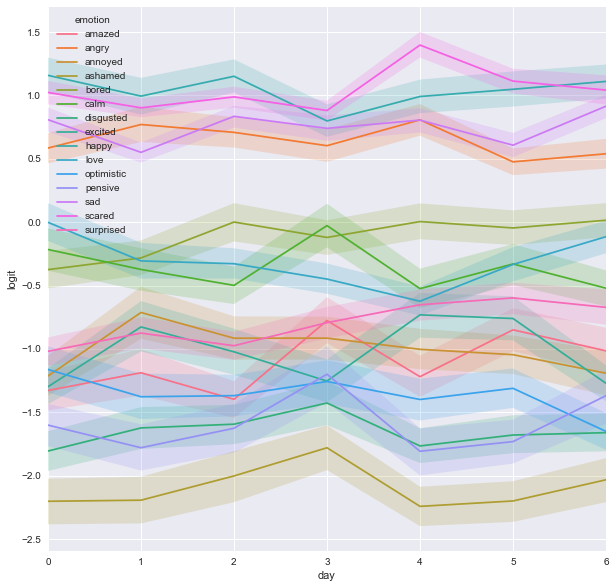

In [91]:
plt.figure(figsize=(10, 10))
ax = sns.tsplot(time='day', value='logit',
                unit='post', condition='emotion',
                data=df_week)
plt.show()

## Oasis dataset

In [3]:
import pandas as pd
df_oasis = pd.read_csv('data/oasis/OASIS.csv', encoding='utf-8')
df_oasis.head()

,Unnamed: 0,Theme,Category,Source,Valence_mean,Valence_SD,Valence_N,Arousal_mean,Arousal_SD,Arousal_N
0,I1,Acorns 1,Object,Pixabay,4.686275,0.954203,102,2.346535,1.602720,101
1,I2,Acorns 2,Object,Pixabay,4.519608,0.841150,102,2.227723,1.399151,101
2,I3,Acorns 3,Object,Pixabay,4.754902,0.958921,102,2.306931,1.514877,101
3,I4,Alcohol 1,Object,Pixabay,4.685185,1.189111,108,2.865385,1.695555,104
4,I5,Alcohol 2,Object,Pixabay,4.250000,1.136686,108,3.000000,1.700942,104


In [119]:
from text_model.text_preprocessing import _paragraph_to_ids, _load_embedding_weights_glove
from scipy.misc import imread, imresize

def load_image(name):
    im_path = 'data/oasis/images/' + name.strip() + '.jpg'
    one_im = imread(im_path)
    return imresize(one_im, ((224, 224, 3)))
    
df_oasis['image'] = df_oasis['Theme'].map(lambda x: load_image(x))

df_oasis['Theme'] = df_oasis['Theme'].map(lambda x: ''.join([i for i in x if not i.isdigit()]).strip())
post_size = 50
text_dir = 'text_model'
emb_dir = 'embedding_weights'
filename = 'glove.6B.50d.txt'
vocabulary, embedding = _load_embedding_weights_glove(text_dir, emb_dir, filename)
word_to_id = dict(zip(vocabulary, range(len(vocabulary))))
df_oasis['text_list'], df_oasis['text_len'] = zip(*df_oasis['Theme'].map(lambda x: 
                                                                        _paragraph_to_ids(x, word_to_id, 
                                                                                          post_size, emotions='')))

Finished loading word embedding weights.


In [120]:
df_oasis['text_list'][(i * batch_size):((i+1) * batch_size)]

0    [54137, 400000, 400000, 400000, 400000, 400000...
1    [54137, 400000, 400000, 400000, 400000, 400000...
2    [54137, 400000, 400000, 400000, 400000, 400000...
3    [4027, 400000, 400000, 400000, 400000, 400000,...
4    [4027, 400000, 400000, 400000, 400000, 400000,...
5    [4027, 400000, 400000, 400000, 400000, 400000,...
6    [4027, 400000, 400000, 400000, 400000, 400000,...
7    [4027, 400000, 400000, 400000, 400000, 400000,...
8    [4027, 400000, 400000, 400000, 400000, 400000,...
9    [4027, 400000, 400000, 400000, 400000, 400000,...
Name: text_list, dtype: object

In [1]:
# change nb iter and nb emotions
from image_text_model.im_text_rnn_model import oasis_evaluation

#change nb batches and nb_emotions
checkpoint_dir = 'image_text_model/deep_sentiment_model'
scores = oasis_evaluation(checkpoint_dir)

Finished loading word embedding weights.
Finished loading word embedding weights.
(1,)


ValueError: setting an array element with a sequence.

In [8]:
df_oasis['Category'][0:1].values.shape

(1,)

In [3]:
scores.shape

(100, 8)

In [8]:
scores_temp = np.hstack([scores, scores])
scores_temp.shape

(100, 16)

In [12]:
scores = np.load('data/oasis_logits.npy')
transformed_oasis = pca.transform(scores)

In [130]:
average_valence = df_oasis['Valence_mean'].mean()
average_arousal = df_oasis['Arousal_mean'].mean()

def categorise(val, arou):
    if val > average_valence:
        if arou > average_arousal:
            return 'Positive Valence - High Affect'
        else:
            return 'Positive Valence - Low Affect'
    else:
        if arou > average_arousal:
            return 'Negative Valence - High Affect'
        else:
            return 'Negative Valence - Low Affect'
        
df_oasis['category'] = df_oasis[['Valence_mean', 'Arousal_mean']].apply(lambda x: categorise(x[0], x[1]), axis=1)
categories = df_oasis['category']
unique_categories = np.unique(df_oasis['category'].values)

In [131]:
# Compare to valence and affect 
import plotly.plotly as py
from plotly.graph_objs import *
import plotly.tools as tls

tls.set_credentials_file(username='anth.hu', api_key='MxqFuCEwTiyJwJeBqfrU')
# plot explained variance https://plot.ly/ipython-notebooks/principal-component-analysis/

traces = []

for categ in unique_categories:
    mask = categories == categ
    if True:
        trace = Scatter(
            x=-transformed_oasis[mask, 0],
            y=-transformed_oasis[mask, 1],
            mode='markers',
            name=categ,
            marker=Marker(
                size=12,
                line=Line(
                    color='rgba(217, 217, 217, 0.14)',
                    width=.5),
                opacity=0.8))
        traces.append(trace)


data = Data(traces)
layout = Layout(xaxis=XAxis(title='Dimension 1', showline=False),
                yaxis=YAxis(title='Dimension 2', showline=False))
fig = Figure(data=data, layout=layout)
py.iplot(fig)

In [125]:
id_to_word = dict(zip(range(len(vocabulary)), vocabulary))

In [96]:
labels_dict

{0: u'amazed',
 1: u'angry',
 2: u'annoyed',
 3: u'ashamed',
 4: u'bored',
 5: u'calm',
 6: u'disgusted',
 7: u'excited',
 8: u'happy',
 9: u'interested',
 10: u'love',
 11: u'optimistic',
 12: u'pensive',
 13: u'sad',
 14: u'scared',
 15: u'surprised'}

In [34]:
np.corrcoef(-transformed_oasis)

array([[ 1.        ,  1.        ,  1.        , ..., -0.42805045,
        -0.42805045, -0.96183386],
       [ 1.        ,  1.        ,  1.        , ..., -0.42805045,
        -0.42805045, -0.96183386],
       [ 1.        ,  1.        ,  1.        , ..., -0.42805045,
        -0.42805045, -0.96183386],
       ..., 
       [-0.42805045, -0.42805045, -0.42805045, ...,  1.        ,
         1.        ,  0.16441526],
       [-0.42805045, -0.42805045, -0.42805045, ...,  1.        ,
         1.        ,  0.16441526],
       [-0.96183386, -0.96183386, -0.96183386, ...,  0.16441526,
         0.16441526,  1.        ]])

In [46]:
oasis_corr = np.corrcoef(np.hstack([transformed_oasis, df_oasis[['Arousal_mean', 'Valence_mean']].values.reshape((-1, 2))]).T)

In [28]:
np.corrcoef(-transformed_oasis[:, 1], df_oasis['Arousal_mean'].values)

array([[ 1.        ,  0.22172661],
       [ 0.22172661,  1.        ]])

In [29]:
np.corrcoef(-transformed_oasis[:, 2], df_oasis['Arousal_mean'].values)

array([[ 1.        ,  0.11011214],
       [ 0.11011214,  1.        ]])

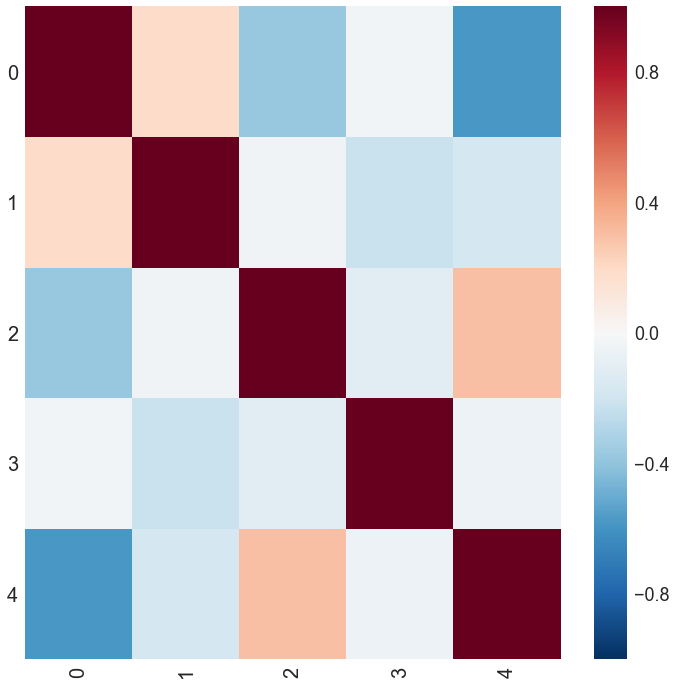

In [47]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(oasis_corr, ax=ax)
graph_labels = [(int)(item.get_text()) for item in ax.get_xticklabels()]
#ax.set_xticklabels(map(lambda x: labels_dict[x], graph_labels))
#ax.set_yticklabels(map(lambda x: labels_dict[x], graph_labels[::-1]))
for label in (ax.get_xticklabels()):
    label.set_fontsize(20)
for label in (ax.get_yticklabels()):
    label.set_fontsize(20)
# Legend ticks size
cax = plt.gcf().axes[-1]
cax.tick_params(labelsize=18)

plt.xticks(rotation=90)
plt.yticks(rotation=0)
#plt.savefig('plots/correlation_matrix.pdf', dpi=300)
plt.show()